In [22]:
#start with new dataset
# commit messages , class : random forest, nueral network (compare results)
#metrics class : random forest, nueral network (compare results)
#imported all required libraries 
import pandas as pd
import numpy as np
from keras.preprocessing.text import one_hot  #import library for hot-encoding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential #import needed functions for LSTM
from keras.layers.core import Activation, Dropout, Dense #import functions needed for LSTM
from keras.layers import Flatten, LSTM  #import LSTM framework 
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding  #import libraries required for word-embeddings 
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import matplotlib.pyplot as plt
from numpy import array
import re #to handle regex 
import matplotlib.pyplot as plt # for plotting charts
import seaborn as sns # to plot charts
from sklearn.preprocessing import StandardScaler # to test sklearn
import keras # Imports keras framework 
from sklearn import preprocessing
from keras.utils import to_categorical
import tensorflow as tf # Import tensorflow framework
from keras import backend as K
from nltk.corpus import stopwords
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
#from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
#from gensim.models import KeyedVectors
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
#Read the dataset into dataframe 
df_c = pd.read_csv('C:/Users/Priya/Desktop/IndependentStudy/commit_text.csv')

In [3]:
#print dataframe
df_c

,Commit message,Class
0,extract method.,extract
1,Minor tweaks following review extraction of me...,extract
2,extract some stuff to a method[git p4: depot p...,extract
3,extract some methods in DoiServiceImpl,extract
4,refactoring getMenuSpace in Navigation: extrac...,extract
...,...,...
4999,Rename getProtocol to getMechanism in TestClient,rename
5000,Rename mapping methods to mapFrom/mapTo Signe...,rename
5001,renaming refactor on deserialization related c...,rename
5002,renamed usage to description to match the name...,rename


In [4]:
#drop NANs
df_c=df_c.dropna()

In [5]:
#print dataframe df_c
df_c

,Commit message,Class
0,extract method.,extract
1,Minor tweaks following review extraction of me...,extract
2,extract some stuff to a method[git p4: depot p...,extract
3,extract some methods in DoiServiceImpl,extract
4,refactoring getMenuSpace in Navigation: extrac...,extract
...,...,...
4999,Rename getProtocol to getMechanism in TestClient,rename
5000,Rename mapping methods to mapFrom/mapTo Signe...,rename
5001,renaming refactor on deserialization related c...,rename
5002,renamed usage to description to match the name...,rename


In [6]:
#randomie the dataset 
df_c= df_c.sample(frac=1)

In [7]:
#check the classes
df_c.Class.unique()

array(['pull up', 'extract', 'move', 'rename', 'push down', 'inline'],
      dtype=object)

In [9]:
#there are 6 classes
#print the count of each classes
df_c['Class'].value_counts()

rename       834
pull up      834
extract      834
push down    834
inline       834
move         834
Name: Class, dtype: int64

In [13]:
df_c = df_c.reset_index(drop=True)
char_replace = re.compile('[/(){}\[\]\|@,;]')
symbol_replace = re.compile('[^0-9a-z #+_]')
stop_w = set(stopwords.words('english'))

def preprocess_commits(text):
    """
    function to clean commit text
    """
    text = text.lower() # lowercase text
    text = char_replace.sub(' ', text) 
    text = symbol_replace.sub('', text)  
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in stop_w) # remove stopwors from text
    return text

In [14]:
df_c['Commit message'] = df_c['Commit message'].apply(preprocess_commits)
df_c['Commit message'] = df_c['Commit message'].str.replace('\d+', '')

In [15]:
#print preprocessed commit messages
df_c['Commit message']

0       biserver  intitial refactor editor classes sup...
1       move languages certificates year film content ...
2                             add support readvalues well
3       dependency fiing added lahttpparser used eplic...
4       refactoring move calendar classes new calendar...
                              ...                        
4999    refactor towards composed method renamed show ...
5000    resolved issue dirmina  change mina create hea...
5001                                         code etracts
5002                       refactored routesolver classes
5003    df# qcadoomes moved filling quantities beforer...
Name: Commit message, Length: 5004, dtype: object

In [16]:
# The maximum number of words to be used. (most frequent)
max_words = 50000
# Max number of words in each commit
max_sequence = 100
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_c['Commit message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14868 unique tokens.


In [17]:
#truncate the text and padding
X = tokenizer.texts_to_sequences(df_c['Commit message'].values)
X = pad_sequences(X, maxlen=max_sequence)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5004, 100)


In [19]:
#convert refactoring classes to numbers 
Y = pd.get_dummies(df_c['Class']).values
print('Shape of tensor:', Y.shape)

Shape of tensor: (5004, 6)


In [20]:
#split train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4503, 100) (4503, 6)
(501, 100) (501, 6)


In [24]:
#functions to calculate keras custom metrics
'''
function to calculate recall metrics of the model
Recall = TruePositives / (TruePositives + FalseNegatives)
Y_t: true values
Y_p: predicted true values 

'''
def recall(Y_t, Y_p):
    Y_t = K.ones_like(Y_t) 
    true_positives = K.sum(K.round(K.clip(Y_t * Y_p, 0, 1)))
    all_positives = K.sum(K.round(K.clip(Y_t, 0, 1)))
    recall = true_positives / (all_positives + K.epsilon())
    return recall

'''
function to calculate precision of the model
Precision= TruePositives / (TruePositives + FalsePositives)
Y_t: true values
Y_p: predicted true values 
'''
def precision(Y_t, Y_p):
    Y_t = K.ones_like(Y_t) 
    true_positives = K.sum(K.round(K.clip(Y_t * Y_p, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(Y_p, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

'''
function to calculate F-1 score of the model
F-1 score=  (2 * Precision * Recall) / (Precision + Recall)
Y_t: true values
Y_p: predicted true values 
'''
def f1_score(Y_t, Y_p):
    pr = precision(Y_t, Y_p)
    rc = recall(Y_t, Y_p)
    return 2*((pr*rc)/(pr+rc+K.epsilon()))

In [25]:
#build the LSTM model  
model = Sequential()
model.add(Embedding(max_words, EMBEDDING_DIM, input_length=X.shape[1])) #create embedding layer
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))  #there are 6 classes total
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_score, precision, recall])
#define hyperparameters 
lstm_m = model.fit(X_train, Y_train, epochs=5, batch_size=128 ,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
64/64 [==============================] - 22s 348ms/step - loss: 1.7477 - accuracy: 0.2384 - f1_score: 9.6154e-04 - precision: 0.0312 - recall: 4.8828e-04 - val_loss: 1.6404 - val_accuracy: 0.3237 - val_f1_score: 6.4935e-04 - val_precision: 0.1250 - val_recall: 3.2552e-04
Epoch 2/5
64/64 [==============================] - 23s 359ms/step - loss: 1.3681 - accuracy: 0.4640 - f1_score: 0.0657 - precision: 0.9688 - recall: 0.0342 - val_loss: 1.2487 - val_accuracy: 0.4745 - val_f1_score: 0.1045 - val_precision: 1.0000 - val_recall: 0.0566
Epoch 3/5
64/64 [==============================] - 24s 369ms/step - loss: 0.9746 - accuracy: 0.6340 - f1_score: 0.1333 - precision: 1.0000 - recall: 0.0716 - val_loss: 1.1222 - val_accuracy: 0.6142 - val_f1_score: 0.1517 - val_precision: 1.0000 - val_recall: 0.0830
Epoch 4/5
64/64 [==============================] - 23s 355ms/step - loss: 0.7229 - accuracy: 0.7453 - f1_score: 0.1906 - precision: 1.0000 - recall: 0.1055 - val_loss: 1.1375 - val_accur

In [26]:
#evalate the model and print metrics values 
sc = model.evaluate(x=[X_test], y=Y_test, verbose=1)
print("Test Score:", sc[0])
print("Test Accuracy:", sc[1])
print("F-1 score", sc[2])
print("Precision", sc[3])
print("Recall", sc[4])

16/16 [==============================] - 0s 25ms/step - loss: 1.2602 - accuracy: 0.5749 - f1_score: 0.2209 - precision: 1.0000 - recall: 0.1243
Test Score: 1.2601966857910156
Test Accuracy: 0.57485032081604
F-1 score 0.22094234824180603
Precision 1.0
Recall 0.1243024542927742


In [27]:
#print the metrics per class
from sklearn.metrics import classification_report
import numpy as np

y_test = np.argmax(Y_test, axis=1) # Convert one-hot encoding to index 
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.70      0.51      0.59        79
           1       0.51      0.48      0.49        82
           2       0.70      0.51      0.59       110
           3       0.34      0.60      0.43        73
           4       0.48      0.48      0.48        84
           5       0.95      0.95      0.95        73

    accuracy                           0.57       501
   macro avg       0.61      0.59      0.59       501
weighted avg       0.61      0.57      0.58       501



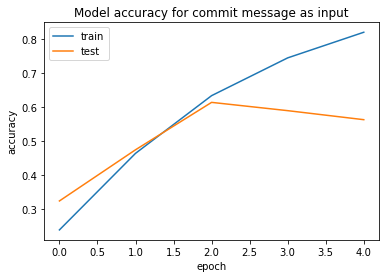

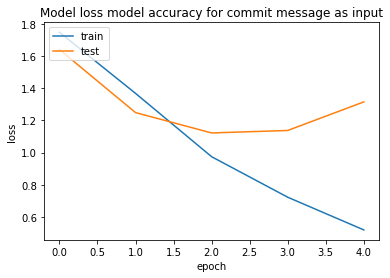

In [28]:
plt.plot(lstm_m.history['accuracy'])
plt.plot(lstm_m.history['val_accuracy'])

plt.title('Model accuracy for commit message as input')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_m.history['loss'])
plt.plot(lstm_m.history['val_loss'])

plt.title('Model loss model accuracy for commit message as input')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()